In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

All columns with the `feat_*` prefix are boolean, integer, or float features that describe the residue itself.  These can be used for training a model.  Domain knowledge of these values should not be necessary to participate in the challenge, but we've provided brief descriptions below for anyone who may be interested:

* `feat_[letter]` are one-hot encoded boolean values for each of the 20 possible amino acids.
* `feat_PHI`, `feat_PSI`, `feat_TAU`, `feat_THETA` describe various protein chain bonding angles, computed with [Biopython](https://biopython.org/docs/1.75/api/Bio.PDB.Polypeptide.html).
* `feat_BBSASA`, `feat_SCSASA` describe the solvent accessible surface area, calculated using [FreeSASA](https://freesasa.github.io/).
* `feat_pLDDT` is an AlphaFold2 residue-level prediction confidence value.
* `feat_DSSP_[letter]` are secondary structure assignments by [DSSP](https://en.wikipedia.org/wiki/DSSP_(algorithm)).
* `feat_DSSP_[number]` are other backbone structural features describing backbone hydrogen. bonding networks, also assigned by [DSSP](https://en.wikipedia.org/wiki/DSSP_(algorithm)).

Column `y_Ligand` indicates if the residue (row) belongs to a known binding site or not.  This column is the classification objective for our challenge. 

The remaining columns describe other elements of the protein structure for reference or troubleshooting purposes.  Participants may use this information to to engineer new features/representations in their models if they so choose. These include:
* `annotation_sequence` and `annotation_atomrec`: Residue amino acid in character format.
* `entry`: Protein name, can be looked up on Uniprot for more information about the protein.  Each unique entry is one unique protein structure in this dataset.
* `coord_X`, `coord_Y`, `coord_Z`: XYZ coordinates of the residue in the respective protein structure.  For example, all residues for protein 'QCR1_HUMAN' belong to the same coordinate space, but the coordinate space would shared between two residues (rows) with `entry` values of 'QCR1_HUMAN' and 'PPM1A_HUMAN'.
* `entry_index`: The order of the amino acid within the protein sequence.  As with coordinates, these relationships are only meaningful for rows (residues) that share the same `entry` value.  For example, within QCR1_HUMAN two residues (rows) with `entry_index` 5 and 6 are adjacent (connected) neighbors.

The test dataset has the same format, but is otherwise missing the `y_Ligand` column. 

In [2]:
import tensorflow as tf
# Disable the GPU for training because it is slower than using CPU
# This is likely due to the small size of the dataset / batch size
tf.config.experimental.set_visible_devices([], 'GPU')

2023-02-23 22:54:08.274197: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 22:54:10.167567: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/andrey/miniconda3/envs/TF_GPU/lib/
2023-02-23 22:54:10.167802: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/andrey/miniconda3/envs/TF_GPU/lib/
2023-02-23 22:54:10.167816: W tensorflow/compi

### Loading the dataset


- Scaling data
- Engineering feature
- Splitting data
- Oversampling due to class imbalance

In [ ]:
from numpy.random import seed
seed(42)

In [10]:
df_train = pd.read_csv("af2_dataset_training_labeled.csv.gz", index_col=0)
df_train.reset_index(inplace=True, drop=True)

# Separate features and labels
X = df_train.drop(columns=['annotation_sequence', 'annotation_atomrec', 'y_Ligand'])
y = df_train['y_Ligand'].astype(int)

In [11]:
# Find the total length of the sequence for each entry
temp = X[['entry', 'entry_index']].groupby('entry').max()

def engineer_index(x):
    return x['entry_index'] / temp['entry_index'][x['entry']]

X['index_engineered'] = X[['entry', 'entry_index']].apply(engineer_index, axis=1)
X.drop(columns=['entry', 'entry_index'], inplace=True)

In [12]:
# Fit the scaler
scaler = StandardScaler()
scaler.fit(X)

# Scale each feature
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

# Reset the index engineered column, as it doens't need to be scaled relative to all other rows
X_scaled['index_engineered'] = X['index_engineered']

# Convert boolean columns to integers, do after scaling so it doesn't get scaled
X_converted = pd.merge(X_scaled.select_dtypes(include=['bool']).astype(int),
                       X_scaled.select_dtypes(exclude=['bool']),
                       left_index=True, right_index=True)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_converted, y, test_size=0.2, random_state=42)

# Oversample the minority class
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

Looking at feature importance, and seeing which ones we should prioritize in our datasets

We weren't able to get the feature importance from the neural network, but we were able to get it from the random forest classifier.

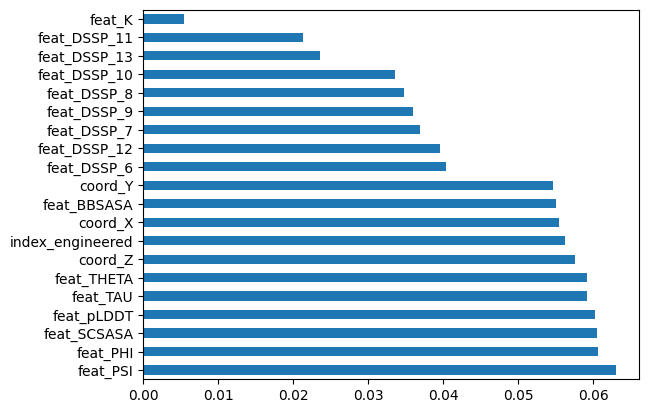

In [17]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# train random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_converted, y)

# plot feature importances
feat_importances = pd.Series(rf.feature_importances_, index=X_converted.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

### Model

We experimented with a number of models, most notably a variety of neural networks and XGBoost.


#### Neural Network

In [4]:
import keras.models as models
import keras.layers as layers
import keras.optimizers as optimizers
import keras.metrics as metrics
import keras.callbacks as callbacks

In [ ]:
data_in = layers.Input(shape=(46,))
x = layers.Dense(64, activation='relu')(data_in)
x = layers.Dropout(0.2)(x)
x = layers.Reshape((1, 64))(x)
x = layers.GlobalAvgPool1D()(x)
x = layers.Dense(32, activation='relu')(x)
data_out = layers.Dense(1, activation='sigmoid')(x)

In [ ]:
# Create the model
model = models.Model(inputs=data_in, outputs=data_out)
model.compile(
    optimizer=optimizers.adam_v2.Adam(),
    loss='binary_crossentropy',
    metrics=[
        metrics.binary_accuracy,
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.AUC(name='roc_auc'),
        metrics.AUC(name='pr_auc', curve='PR')
    ])
model.summary()

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=3,
            min_lr=1e-04
        ),
        callbacks.ModelCheckpoint(
            filepath='testing.h5',
            monitor='val_roc_auc',
            save_best_only=True
        ),
        callbacks.EarlyStopping(
            monitor='val_roc_auc',
            patience=7
        )
    ])

In [6]:
best_model = models.load_model('best_model_final.h5')

In [25]:
from sklearn.metrics import roc_auc_score

# The ROC AUC is different from the one reported by Tensorflow, we got 0.8504 when training the model (on the same set)
predictions = best_model.predict(X_test)
print(roc_auc_score(y_test, predictions)) # 0.8411

3108/3108 [==============================] - 2s 680us/step
0.841100058646299


In [12]:
import shap

sample = X_train.sample(100, random_state=42)

explainer = shap.KernelExplainer(best_model.predict, sample)
samples = shap.sample(X_test, nsamples=20, random_state=42)

shap_values = explainer.shap_values(samples, nsamples='auto')

/home/andrey/miniconda3/envs/TF_GPU/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4/4 [==============================] - 0s 2ms/step


  0%|          | 0/20 [00:00<?, ?it/s]

6675/6675 [==============================] - 5s 741us/step


  5%|▌         | 1/20 [00:07<02:20,  7.41s/it]

6675/6675 [==============================] - 5s 761us/step


 10%|█         | 2/20 [00:14<02:09,  7.22s/it]

6675/6675 [==============================] - 5s 753us/step


 15%|█▌        | 3/20 [00:21<02:01,  7.12s/it]

6675/6675 [==============================] - 5s 741us/step


 20%|██        | 4/20 [00:28<01:56,  7.25s/it]

6675/6675 [==============================] - 6s 836us/step


 25%|██▌       | 5/20 [00:36<01:52,  7.50s/it]

6675/6675 [==============================] - 5s 768us/step


 30%|███       | 6/20 [00:44<01:43,  7.40s/it]

6675/6675 [==============================] - 5s 724us/step


 35%|███▌      | 7/20 [00:50<01:33,  7.22s/it]

6675/6675 [==============================] - 5s 752us/step


 40%|████      | 8/20 [00:57<01:25,  7.13s/it]

6675/6675 [==============================] - 5s 737us/step


 45%|████▌     | 9/20 [01:04<01:17,  7.04s/it]

6675/6675 [==============================] - 5s 725us/step


 50%|█████     | 10/20 [01:11<01:09,  6.99s/it]

6675/6675 [==============================] - 5s 739us/step


 55%|█████▌    | 11/20 [01:18<01:02,  6.98s/it]

6675/6675 [==============================] - 5s 738us/step


 60%|██████    | 12/20 [01:25<00:55,  6.97s/it]

6675/6675 [==============================] - 5s 744us/step


 65%|██████▌   | 13/20 [01:32<00:48,  6.97s/it]

6675/6675 [==============================] - 5s 738us/step


 70%|███████   | 14/20 [01:39<00:42,  7.02s/it]

6675/6675 [==============================] - 5s 759us/step


 75%|███████▌  | 15/20 [01:46<00:35,  7.12s/it]

6675/6675 [==============================] - 5s 744us/step


 80%|████████  | 16/20 [01:54<00:28,  7.18s/it]

6682/6682 [==============================] - 5s 739us/step


 85%|████████▌ | 17/20 [02:02<00:22,  7.50s/it]

6675/6675 [==============================] - 5s 786us/step


 90%|█████████ | 18/20 [02:09<00:14,  7.43s/it]

6675/6675 [==============================] - 5s 729us/step


 95%|█████████▌| 19/20 [02:16<00:07,  7.25s/it]

6675/6675 [==============================] - 5s 724us/step


100%|██████████| 20/20 [02:23<00:00,  7.17s/it]


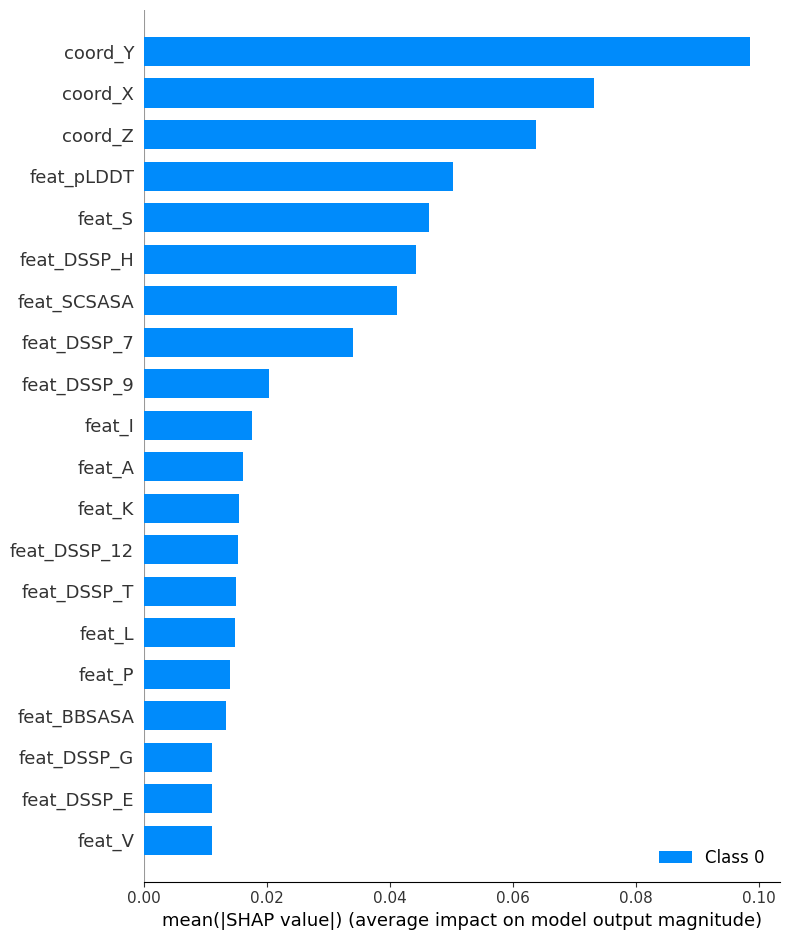

In [13]:
shap.summary_plot(shap_values,X_test,feature_names=X_test.columns)

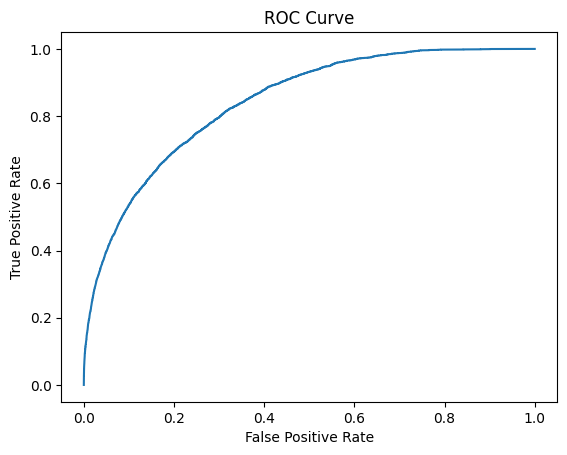

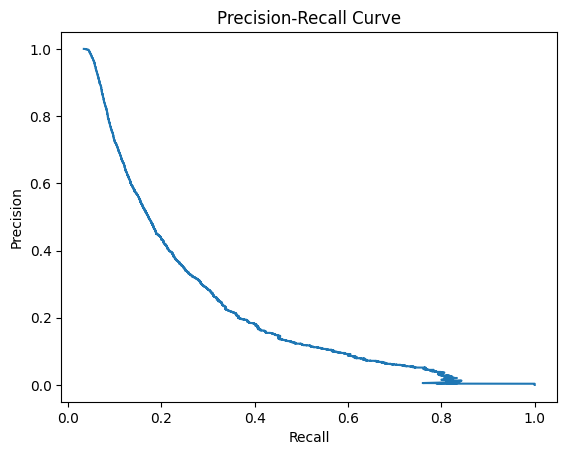

In [16]:
from sklearn.metrics import roc_curve, precision_recall_curve
from matplotlib import pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, predictions)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, predictions)
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_roc_auc'], label='roc_auc')
plt.legend()
plt.show()
plt.plot(history.history['val_pr_auc'], label='pr_auc')
plt.legend()
plt.show()

In [27]:
test_set = pd.read_csv("af2_dataset_testset_unlabeled.csv.gz", index_col=0)
test_set.reset_index(inplace=True, drop=True)

# Separate features and labels
X = test_set.drop(columns=['annotation_sequence', 'annotation_atomrec'])

# Find the total length of the sequence for each entry
temp = X[['entry', 'entry_index']].groupby('entry').max()

def engineer_index(x):
    return x['entry_index'] / temp['entry_index'][x['entry']]

X['index_engineered'] = X[['entry', 'entry_index']].apply(engineer_index, axis=1)
X.drop(columns=['entry', 'entry_index'], inplace=True)

# Fit the scaler
scaler = StandardScaler()
scaler.fit(X)

# Scale each feature
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

# Reset the index engineered column, as it doens't need to be scaled relative to all other rows
X_scaled['index_engineered'] = X['index_engineered']

# Convert boolean columns to integers, do after scaling so it doesn't get scaled
X_converted = pd.merge(X_scaled.select_dtypes(include=['bool']).astype(int),
                       X_scaled.select_dtypes(exclude=['bool']),
                       left_index=True, right_index=True)

predictions = best_model.predict(X_converted)
pd.DataFrame(predictions)[0].round().astype(int).to_csv('predictions.csv')

3364/3364 [==============================] - 2s 684us/step


In [28]:
df = pd.DataFrame(predictions)[0].round().value_counts()

In [32]:
df[1]/df[0]

0.2746372949606206